Test Jacobi-iterator for thermal problems using MFEANet

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.nn.modules.utils import _pair

import numpy as np
import matplotlib.pyplot as plt
import math
import time
from functools import reduce

from utils import plot
from feanet.model import PACFEANet
from feanet.jacobi import JacobiBlock
from feanet.iterator import PsiIterator
from feanet.multigrid import MultiGrid
from data.dataset import MechanicalDataSet


ModuleNotFoundError: No module named 'iterator'

In [ ]:
device_predict = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #torch.device('cpu') #
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
bs = 1 # batch size
k = 0 # test data index
n_test = 2**6
test_set = MechanicalDataSet('data/Ti64/thermal_Ti64.h5', device)
# n_test = 2**5
# test_set = ThermalDataSet('data/thermal/thermal_test.h5', device)
test_dataloader = DataLoader(test_set, batch_size=bs, shuffle=True)
mask_test, dirich_idx_test, dirich_value_test, neumann_value_test, neumann_conn_test, material_test, f_test, u_test = next(iter(test_dataloader))
solution_test, f_test, d_test, d_idx_test, t_test, t_conn_test, m_test, msk_test = (torch.unsqueeze(u_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(f_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_value_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_idx_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_value_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_conn_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(material_test[k], 0).to(device_predict),
                                                                         torch.unsqueeze(mask_test[k], 0).to(device_predict))

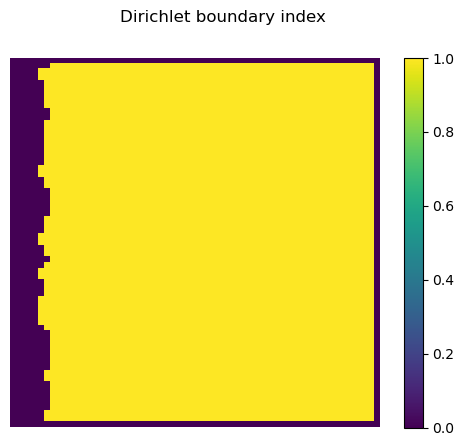

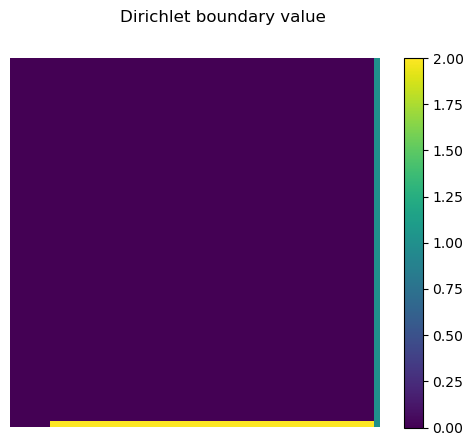

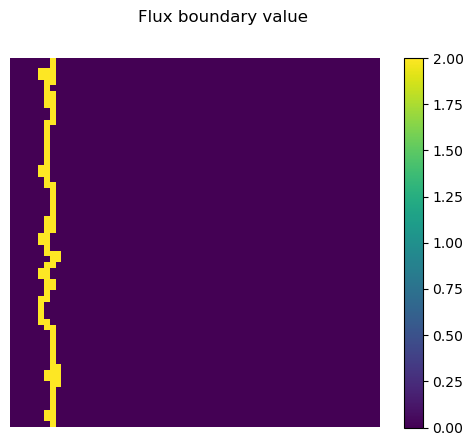

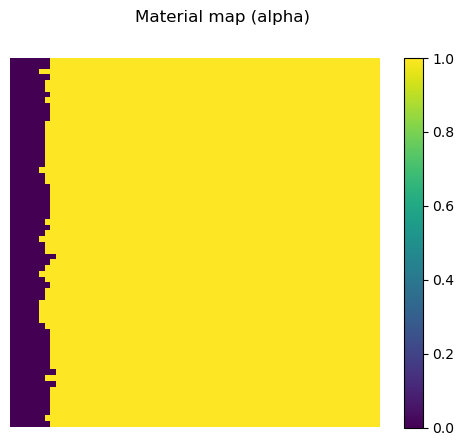

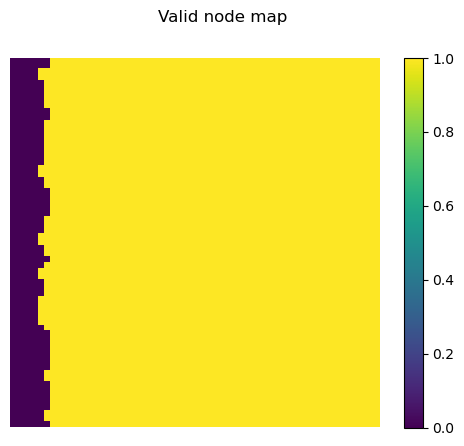

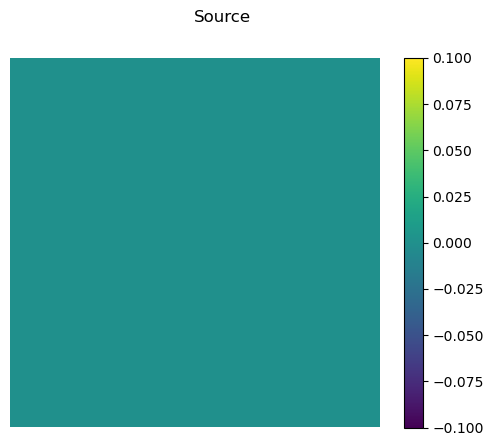

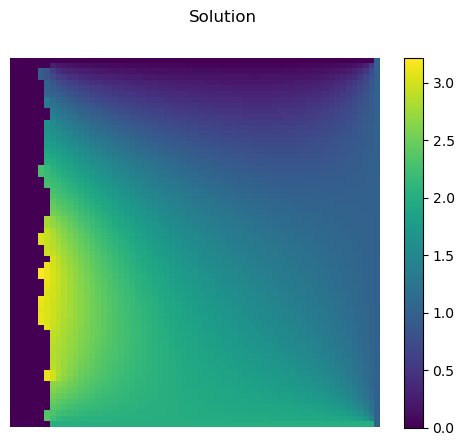

In [ ]:
plot.plot_thermalfield(dirich_idx_test[k], ftitle='Dirichlet boundary index')
plot.plot_thermalfield(dirich_value_test[k], ftitle='Dirichlet boundary value')
plot.plot_thermalfield(neumann_value_test[k], ftitle='Flux boundary value')
plot.plot_thermalfield(material_test[k], ftitle='Material map (alpha)')
plot.plot_thermalfield(mask_test[k], ftitle='Valid node map')
plot.plot_thermalfield(f_test[k], ftitle='Source')
plot.plot_thermalfield(u_test[k], ftitle='Solution')

In [ ]:
class SingleGrid():
    '''
    Perform weighted Jacobi iteration relaxation for a single grid.
    '''
    def __init__(self, h, n_elem, mode, dev):
        self.mode = mode
        self.device = dev
        self.n_elem = n_elem
        self.h = h
        self.v = torch.zeros((1, 1, n_elem+1, n_elem+1), requires_grad=False).double()
        self.f = torch.zeros((1, 1, n_elem+1, n_elem+1), requires_grad=False).double()
        self.net = self.InstantiateNetwork()
        self.jac = JacobiBlock(self.net, self.h, self.device, self.mode)

    def IsCoarsest(self):
        return self.n_elem == 2
        
    def InstantiateNetwork(self):
        model = PACFEANet(self.device, self.mode).double()
        model.requires_grad_(False)
        return model.to(self.device)

In [ ]:
n_elem = n_test
ku, kf = 1, 1
h = 0.0061*4
grid = SingleGrid(h, n_elem=n_elem, mode='thermal', dev=device_predict)

0 10.565256808984309
1 5.900988474921269
2 4.273071811366804
3 3.4130796913376895
4 2.872064118862075
5 2.496482134596629
6 2.218621754491309
7 2.003694943210194
8 1.8318837300446955
9 1.691017674832411
10 1.573181765614125
11 1.4729899395917656
12 1.3866399861157561
13 1.3113651474539532
14 1.2451002954118902
15 1.1862703879833503
16 1.1336517334189653
17 1.0862782626540657
18 1.0433765465284117
19 1.0043197037594653
20 0.9685940423712261
21 0.9357744804256316
22 0.9055061436890283
23 0.8774903892159626
24 0.8514740528105792
25 0.8272410800052162
26 0.8046059432004633
27 0.7834084138472234
28 0.7635093741710807
29 0.7447874345918647
30 0.7271361814741754
31 0.7104619222814021
32 0.6946818263717455
33 0.6797223828198087
34 0.6655181140136766
35 0.6520104969330603
36 0.6391470540686428
37 0.626880583690809
38 0.6151685051926155
39 0.6039722999374749
40 0.5932570317470875
41 0.5829909341006665
42 0.5731450534560777
43 0.5636929399784906
44 0.5546103784726848
45 0.5458751535381612
46 0.53

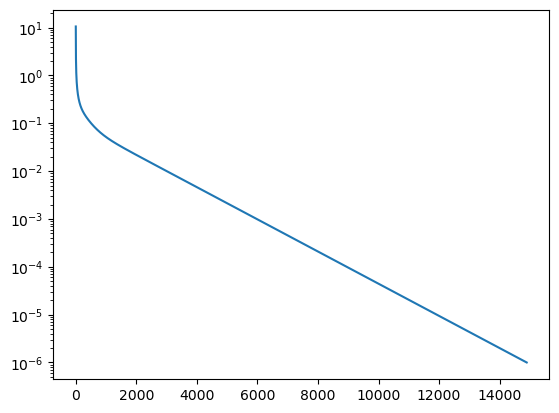

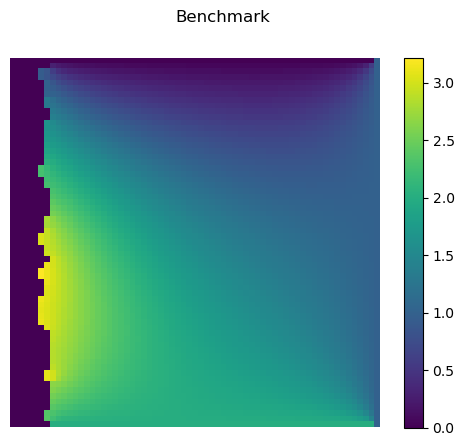

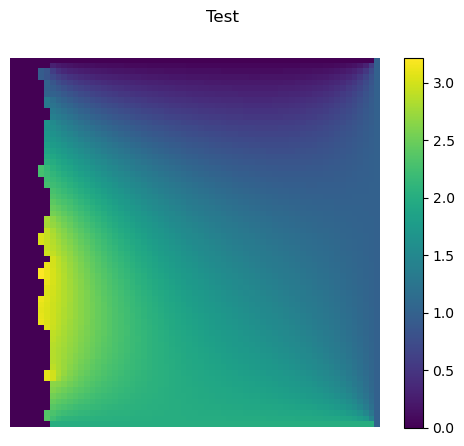

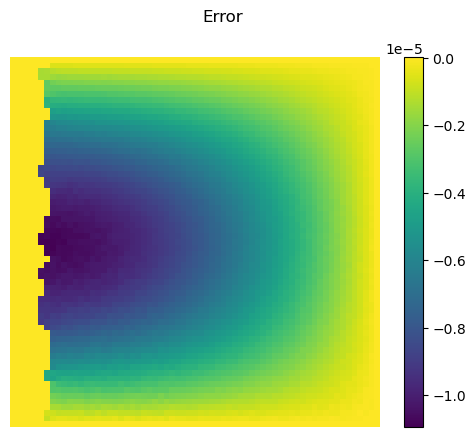

In [ ]:
EPS = 1e-6
n_jac = 0
u_test = torch.ones(size=(1, ku, n_elem+1, n_elem+1), requires_grad=False, dtype=torch.double).to(device_predict)
u_test = grid.jac.reset_boundary(u_test, d_test, d_idx_test)
residual = grid.net(None, None, h, u_test, d_idx_test, f_test, t_test, t_conn_test, m_test, msk_test)
res = torch.norm(residual).item() 
res_arr = [res]

print(n_jac, res)
while (abs(res) > EPS):
    u_test = grid.jac.jacobi_convolution(u_test, m_test, msk_test, d_test, d_idx_test, None, None, h, f_test, t_test, t_conn_test)
    residual = grid.net(None, None, h, u_test, d_idx_test, f_test, t_test, t_conn_test, m_test, msk_test)
    res = torch.norm(residual).item() 
    res_arr.append(res)
    n_jac += 1
    print(n_jac, res)

print("Solution converges after", n_jac, "Jacobi iterations ")
plt.plot(res_arr)
plt.yscale('log')
plt.show()

plot.plot_thermalfield(u_test[0], "Benchmark")
plot.plot_thermalfield(solution_test[0], "Test")
plot.plot_thermalfield(u_test[0]-solution_test[0], 'Error')

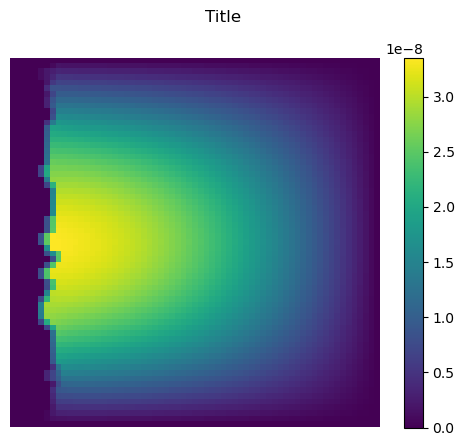

In [ ]:
term_r = residual
plot.plot_thermalfield(term_r[0,0,:,:])

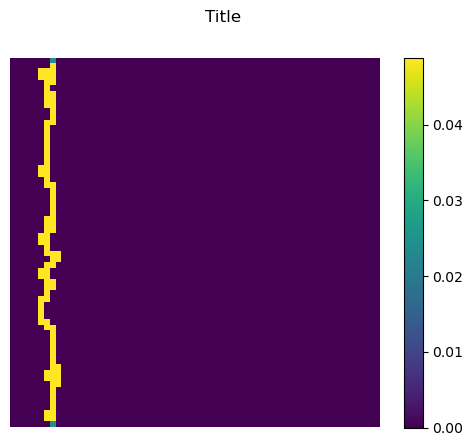

In [ ]:
f_bc = grid.net.term_F
_,_,hs,ws = f_bc.shape
plot.plot_thermalfield(f_bc.reshape(hs,ws))

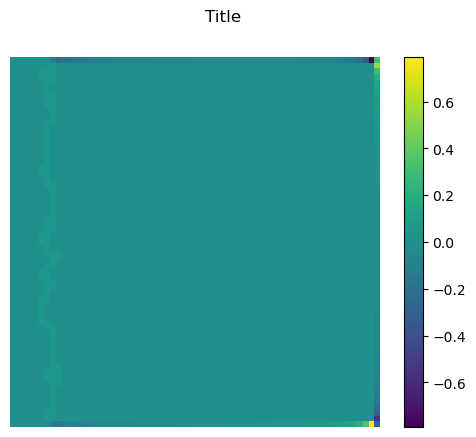

In [ ]:
ku_bc = grid.net.term_KU
_,_,hs,ws = ku_bc.shape
plot.plot_thermalfield(ku_bc.reshape(hs,ws))

## Test multigrid performance

In [ ]:
with torch.no_grad():
    n = n_elem
    h = 2./n
    n_mg_jac = 0
    mg_jac = MultiGrid(h, n, pacnet=None, device=device, nb_layers=3, iterator='jac') # create a multigrid model
    mg_jac.ProblemDictArray(f_test,t_test,t_conn_test,d_test,d_idx_test,m_test,msk_test)
    u_mg_jac = torch.ones((1, 1, n+1, n+1), requires_grad=False, dtype=torch.double).to(device)
    u_mg_jac = mg_jac.iterators[0].grid.jac.reset_boundary(u_mg_jac, d_test, d_idx_test)
    residual = mg_jac.iterators[0].grid.net(None, None, h, u_mg_jac, d_idx_test, f_test, t_test, t_conn_test, m_test,msk_test)
    res = torch.norm(residual).item()
    err_occured = False
    res_arr_mgjac = [res]
    print(n_mg_jac, res)

    start = time.time()
    while (abs(res) > EPS):
        u_mg_jac = mg_jac.Step(u_mg_jac)
        residual = mg_jac.iterators[0].grid.net(None, None, h, u_mg_jac, d_idx_test, f_test, t_test, t_conn_test, m_test, msk_test)
        res = torch.norm(residual).item()
        res_arr_mgjac.append(res)
        n_mg_jac += 1
        print(n_mg_jac, res)

        if(res == torch.inf or math.isnan(res)):
            err_occured = True
            break

    end = time.time()

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_mg_jac, "Jacobi multigrid iterations in", end-start, 'seconds.')


0 10.57239838740194
1 2.4489686294283866
2 0.784830233753101
3 0.4457578312667087
4 0.33892180901722446
5 0.2721097367249261
6 0.2207066922986839
7 0.17960014604323102
8 0.1463596113599187
9 0.11935507345779768
10 0.09736762291227084
11 0.07944490486861126
12 0.06482693832614424
13 0.052900734562540706
14 0.04316911667022238
15 0.03522765513283679
16 0.02874684689312186
17 0.023458003975119372
18 0.019141926975654828
19 0.01561974544205569
20 0.012745479579439353
21 0.010399985588885764
22 0.008486020696376018
23 0.006924217779546346
24 0.00564980056230241
25 0.004609902530903183
26 0.0037613783737032655
27 0.003069017393117379
28 0.0025040850579122072
29 0.0020431324523918406
30 0.0016670244463564523
31 0.001360146435262565
32 0.0011097568658591994
33 0.0009054587764931551
34 0.0007387684924093256
35 0.000602763627402498
36 0.00049179581884097
37 0.00040125629857384296
38 0.00032738458697319895
39 0.000267112381347716
40 0.00021793616684627286
41 0.0001778132672483519
42 0.00014507702

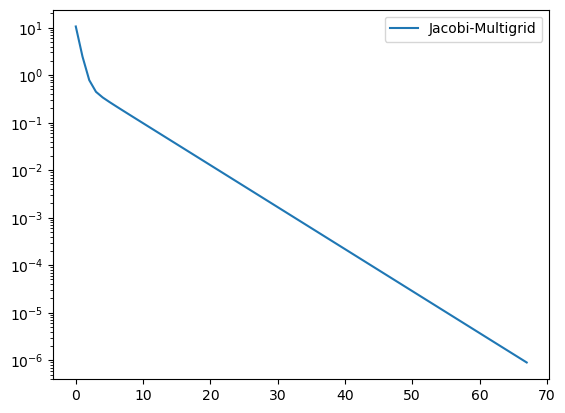

In [ ]:
plt.plot(res_arr_mgjac, label='Jacobi-Multigrid')
plt.yscale('log')
plt.legend()
plt.show()

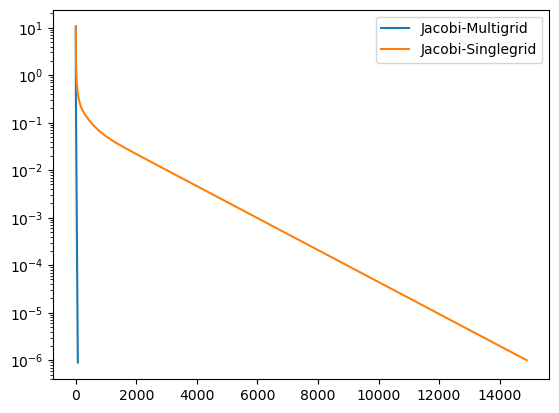

In [ ]:
plt.plot(res_arr_mgjac, label='Jacobi-Multigrid')
plt.plot(res_arr, label='Jacobi-Singlegrid')
plt.yscale('log')
plt.legend()
plt.show()

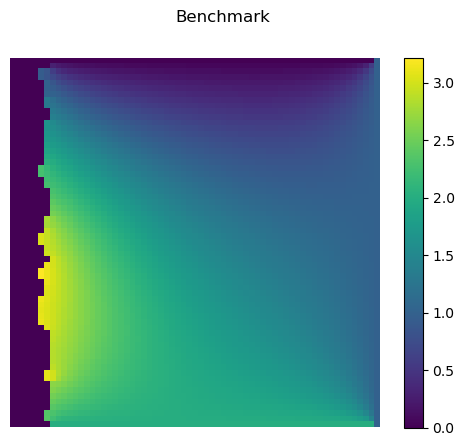

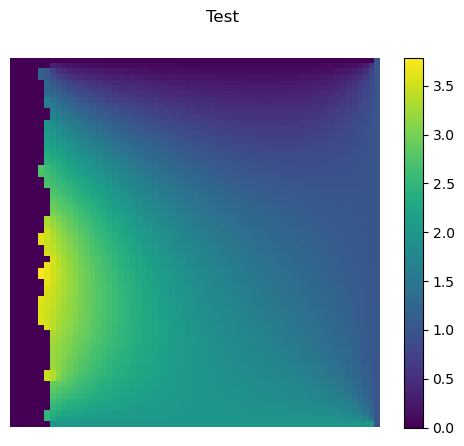

In [ ]:
plot.plot_thermalfield(u_test[0], "Benchmark")
plot.plot_thermalfield(u_mg_jac[0], "Test")